In [2]:
# импортируем нужные библиотеки и модули
import os
import numpy
import math
from scipy import integrate, linalg
from matplotlib import pyplot

# вставляем графику в блокнот
%matplotlib inline

In [3]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)
        
        if xb-xa <= 0.0:
            self.beta = math.acos((yb-ya)/self.length)
        else:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
            
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
            
        self.sigma = 0.                         # интенсивность источника
        self.vt = 0.                            # касательная скорость
        self.cp = 0. 
        self.gamma = 0.

In [4]:
def define_panels(x,y,N):
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
     
    return panels

In [5]:
class Freestream:
   
    def __init__(self, u_inf=1.0, alpha=0.0):
        
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # градусы в радианы

In [6]:
def integral(x, y, panel, dxdk, dydk):
    
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [7]:
def source_contribution_normal(panels):
    
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # вклад рассматриваемой панели в общее поле источников
    numpy.fill_diagonal(A, 0.5)
    # вклад остальных панелей
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [8]:
def vortex_contribution_normal(panels):
    
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # вклад от рассматриваемой панели в поле вихря
    numpy.fill_diagonal(A, 0.0)
    # вихревой вклад от всех остальных панелей
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [9]:
def kutta_condition(A_source, B_vortex, Na):

    b = numpy.empty(shape = (2, A_source.shape[0]+2), dtype=float)
    # матрица вкладов источников в тангенциальную составляющую скорости
    # равна
    # матрице вкладов вихрей в нормальную составляющую скорости
    b[0, :-2] = B_vortex[0, :] + B_vortex[Na - 1, :]
    b[1, :-2] = B_vortex[Na, :] + B_vortex[-1, :]
    # матрица вкладов вихрей в тангенциальную составляющую скорости
    # противоположна по знаку
    # матрице вкладов источников в нормальную составляющую скорости
    b[0, -2] = - numpy.sum(A_source[0, 0:Na] + A_source[Na-1, 0:Na])
    b[0, -1] = - numpy.sum(A_source[0, Na:] + A_source[Na-1, Na:])
    b[1, -2] = - numpy.sum(A_source[Na, 0:Na] + A_source[-1, 0:Na])
    b[1, -1] = - numpy.sum(A_source[Na, Na:] + A_source[-1, Na:])
    return b

In [10]:
def build_singularity_matrix(A_source, B_vortex, Na):

    A = numpy.empty((A_source.shape[0]+2, A_source.shape[1]+2), \
                    dtype=float)
    # матрица источников
    A[:-2, :-2] = A_source
    # матрица вихрей
    A[:-2, -2] = numpy.sum(B_vortex[:, 0:Na], axis=1)
    A[:-2, -1] = numpy.sum(B_vortex[:, Na:], axis=1)
    # условие Кутты-Жуковского
    A[-2:, :] = kutta_condition(A_source, B_vortex, Na)
    return A

In [11]:
def build_freestream_rhs(panels, panels_f, freestream):
   
    b = numpy.empty(panels.size + panels_f.size + 2,dtype=float)
    # вклад от набегающего потока в каждую панель
    for i, panel in enumerate(numpy.append(panels, panels_f)):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # вклад от набегающего потока в условие Кутты-Жуковского
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[-1].beta) ) #предпоследняя ячейка для крыла
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels_f[0].beta)
                               +numpy.sin(freestream.alpha-panels_f[-1].beta) ) #последняя ячейка для закрылка
    return b

In [12]:
def compute_tangential_velocity(panels, panels_f, freestream, gamma, gamma_f, A_source, B_vortex, Na, Nb):

    A = numpy.empty( (Na + Nb, Na + Nb + 2), dtype=float)
    # матрица вкладов источников в тангенциальную составляющую скорости
    # равна
    # матрице вкладов вихрей в нормальную составляющую скорости
    A[:, :-2] = B_vortex
    # матрица вкладов вихрей в тангенциальную составляющую скорости
    # противоположна по знаку
    # матрице вкладов источников в нормальную составляющую скорости
    A[:, -2] = -numpy.sum(A_source[:, 0:Na], axis=1)
    A[:, -1] = -numpy.sum(A_source[:, Na:], axis=1)
    # добавляем набегающий поток
    panels_common = numpy.append(panels, panels_f)
    
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta for panel in panels_common])
    
    strengths = numpy.append([panel.sigma for panel in panels_common], [gamma, gamma_f])
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels_common):
        panel.vt = tangential_velocities[i]

In [13]:
def compute_pressure_coefficient(panels, panels_f, freestream):
 
    panels_common = numpy.append(panels, panels_f)
    
    for panel in panels_common:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [14]:
filepath = os.path.join('NACA23012_MainFoil.csv')
with open(filepath, 'r') as infile:
    x_m_new, y_m_new = numpy.loadtxt(infile, dtype=float, delimiter=',',unpack=True)

filepath_f = os.path.join('NACA23012_FlapFoil.csv')
with open(filepath_f, 'r') as infile:
    x_f, y_f = numpy.loadtxt(infile, dtype=float, delimiter=',',unpack=True)

In [15]:
z_f = x_f + 1j*y_f
z_0 = 1.03 + 1j*0.054

z = (z_f - z_0)*numpy.exp(-20/180*numpy.pi*1j) + z_0

x_f_new = z.real
y_f_new = z.imag

In [16]:
def once_more (x_m, y_m, x_f, y_f, freestream):
    panels_m = define_panels(x_m, y_m, 150)
    panels_f = define_panels(x_f, y_f, 150)

    N_m = len(panels_m)
    N_f = len(panels_f)

    A_source = source_contribution_normal(numpy.append(panels_m, panels_f))
    B_vortex = vortex_contribution_normal(numpy.append(panels_m, panels_f))
    
    A = build_singularity_matrix(A_source, B_vortex, len(x_m) - 1)
    b = build_freestream_rhs(panels_m, panels_f, freestream)
    
    # рассчитываем интенсивности источников и вихря
    strengths = numpy.linalg.solve(A, b)    

    # заполняем интенсивности на кажой панели
    for i , panel in enumerate(panels_m):
        panel.sigma = strengths[i]
    for i , panel in enumerate(panels_f):
        panel.sigma = strengths[i+N_f]

    # запоминаем циркуляцию
    gamma_m = strengths[-2]
    gamma_f = strengths[-1]
    
    # касательная компонента скорости на каждой панели
    compute_tangential_velocity(panels_m, panels_f, freestream, gamma_m, gamma_f, A_source, B_vortex, N_m, N_f)
    
    # коэффициент давления на поверхности
    compute_pressure_coefficient(panels_m, panels_f, freestream)
    
    F_x = 0
    F_y = 0
    for p in numpy.append(panels_m, panels_f):
        F_x += -p.cp*p.length*numpy.cos(p.beta)
        F_y += -p.cp*p.length*numpy.sin(p.beta)


    l = abs(max(x_m) - min(x_m))
    #C_x = F_x/l*numpy.cos(freestream.alpha/180*numpy.pi) + F_y/l*numpy.sin(freestream.alpha/180*numpy.pi)
    C_y = F_y/l*numpy.cos(freestream.alpha/180*numpy.pi) - F_x/l*numpy.sin(freestream.alpha/180*numpy.pi)
    
    return C_y

In [17]:
angle = 20.0*numpy.pi/180 
freestream = Freestream(1, 0)
C_y = once_more(x_m_new, y_m_new, x_f_new, y_f_new, freestream)
    
C_y  

1.4673478434215226

In [34]:
angle_from = -14
angle_to = 14

eps = 0.01


while abs(angle_from - angle_to) > eps:
    
    u_inf = 1.
    angle_mid = (angle_from + angle_to)/2
    
    freestream = Freestream(u_inf, angle_mid)
    C_y = once_more(x_m_new, y_m_new, x_f_new, y_f_new, freestream)
        
    print(C_y)
    if C_y > 0:
        angle_to = angle_mid
    else:
        angle_from = angle_mid
    print(" a =",angle_from, " b =",angle_to)

1.4673478434215226
 a = -14  b = 0.0
0.5194012477715335
 a = -14  b = -7.0
0.046524329613546175
 a = -14  b = -10.5
-0.18662523174482032
 a = -12.25  b = -10.5
-0.07041340708606283
 a = -11.375  b = -10.5
-0.012028650893449778
 a = -10.9375  b = -10.5


KeyboardInterrupt: 

In [23]:
x_c = 1.03
y_c = -0.054
angle_1 = 0.0
angle_2 = -5.0*numpy.pi/180 
angle_3 = -10.0*numpy.pi/180
angle_4 = -15.0*numpy.pi/180

x_f_new_1 = x_c + (x_f - x_c)*math.cos(angle_1) - (y_f - y_c)*math.sin(angle_1)
y_f_new_1 = y_c + (x_f - x_c)*math.sin(angle_1) + (y_f - y_c)*math.cos(angle_1)

x_f_new_2 = x_c + (x_f - x_c)*math.cos(angle_2) - (y_f - y_c)*math.sin(angle_2)
y_f_new_2 = y_c + (x_f - x_c)*math.sin(angle_2) + (y_f - y_c)*math.cos(angle_2)

x_f_new_3 = x_c + (x_f - x_c)*math.cos(angle_3) - (y_f - y_c)*math.sin(angle_3)
y_f_new_3 = y_c + (x_f - x_c)*math.sin(angle_3) + (y_f - y_c)*math.cos(angle_3)

x_f_new_4 = x_c + (x_f - x_c)*math.cos(angle_4) - (y_f - y_c)*math.sin(angle_4)
y_f_new_4 = y_c + (x_f - x_c)*math.sin(angle_4) + (y_f - y_c)*math.cos(angle_4)


freestream = Freestream(1, 4.0*numpy.pi/180)
C_y_1 = once_more(x_m_new, y_m_new, x_f_new_1, y_f_new_1, freestream)
C_y_2 = once_more(x_m_new, y_m_new, x_f_new_2, y_f_new_2, freestream)
C_y_3 = once_more(x_m_new, y_m_new, x_f_new_3, y_f_new_3, freestream)
C_y_4 = once_more(x_m_new, y_m_new, x_f_new_4, y_f_new_4, freestream)

In [24]:
print(C_y_1, C_y_2, C_y_3, C_y_4)

0.28160696497984383 0.5873441985742753 0.8974682260442098 1.2117666634517505


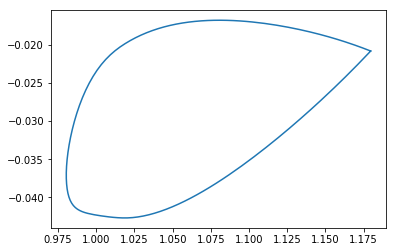

In [22]:
pyplot.plot(x_f_new_2,y_f_new_2)